In [98]:
# Standard library imports
from collections import OrderedDict
import gzip
from pathlib import Path

# Third party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.rnn_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
from torchvision.utils import save_image
from torch import nn
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.rnn_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [84]:
step = 1/24
end = 5
n_steps = 120
time = np.arange(step, end+step, step)

In [85]:
X = []
for i in range(7):
    intercept, coef_cos1, coef_cos2, coef_cos3, coef_sin1, coef_sin2, coef_sin3 = np.random.rand(7)
    x = (
        coef_cos1 * np.cos(time * 1 * 2 * np.pi)
        + coef_sin1 * np.sin(time * 1 * 2 * np.pi)
        + coef_cos2 * np.cos(time * 2 * 2 * np.pi)
        + coef_sin2 * np.sin(time * 2 * 2 * np.pi)
        + coef_cos3 * np.cos(time * 3 * 2 * np.pi)
        + coef_sin3 * np.sin(time * 3 * 2 * np.pi)
        + np.random.rand(time.shape[0])
    )
    X.append(x)
X = np.stack(X, axis=1)
X.shape

(120, 7)

In [86]:
y = X.sum(axis=1)


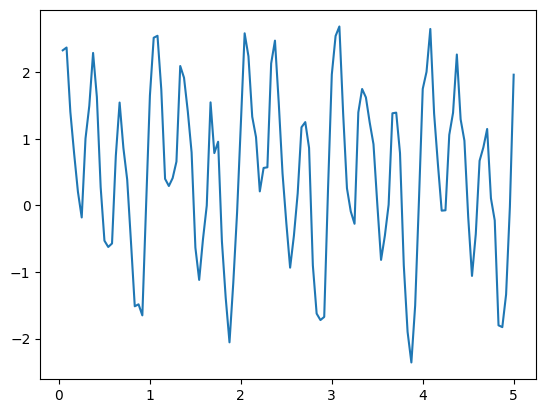

In [87]:

plt.plot(time, X[:, 5])

In [200]:
# From https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch
# Create RNN rnn
class RNNrnn(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNrnn, self).__init__()
        self.input_dim = input_dim
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        # h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        h0 = Variable(torch.zeros(self.input_dim, self.hidden_dim)).type(torch.float64)
        h0 = Variable(torch.zeros(1,3)).type(torch.float64)
        print(x.shape, h0.shape)
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out


In [201]:


features_train, features_test, targets_train, targets_test = train_test_split(X,
                                                                             X,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train)

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test)

In [208]:
# batch_size, epoch and iteration
batch_size = 2
n_iters = 1000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [209]:
# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)



In [210]:
input_dim = 7  # input dimension
hidden_dim = 3 # hidden layer dimension
layer_dim = 1  # number of hidden layers
output_dim = input_dim  # output dimension
rnn = RNNrnn(input_dim, hidden_dim, layer_dim, output_dim)
error = nn.CrossEntropyLoss()
# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [211]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train  = Variable(images.view(-1, input_dim))
        labels = Variable(labels )
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = rnn(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = images.view(-1, 7)#Variable(images.view(-1, input_dim)).type(torch.float64)
                optimizer.zero_grad()
                # Forward propagation
                outputs = rnn(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))


torch.Size([2, 7]) torch.Size([1, 3])


RuntimeError: mat1 and mat2 must have the same dtype

In [206]:
images.dtype

torch.float64

In [154]:
images.dtype

torch.float64

In [136]:
images.view(-1, input_dim).shape

torch.Size([1, 7])